## Multi-classification problem


In [2]:
# Uncomment the next line to install packages
# pip install torch torchvision matplotlib pandas seaborn requests 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [2]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [3]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [4]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [5]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [6]:
# Let's look at a data point
sample_index = 88

data_sample = dataset.data[sample_index]
target_sample = dataset.targets[sample_index]
print("Sample type and shape : ",type(data_sample),data_sample.shape)
print("Label type and value : " ,type(target_sample),target_sample)

Sample type and shape :  <class 'numpy.ndarray'> (16, 16)
Label type and value :  <class 'int'> 9


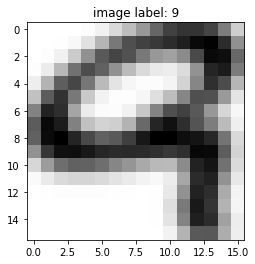

In [7]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])
plt.show()

## Pytorch Tensor

Pytorch Documentation : https://pytorch.org/docs/stable/index.html

In [8]:
tensor_data_point = torch.tensor(data_sample)
print("Tensor type :",type(tensor_data_point),", and shape : ",tensor_data_point.shape)

Tensor type : <class 'torch.Tensor'> , and shape :  torch.Size([16, 16])


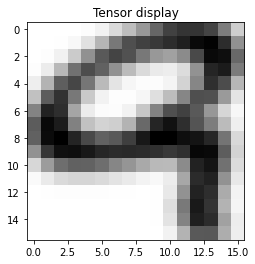

In [9]:
# Pyplot can manage torch Tensors
plt.imshow(tensor_data_point, cmap=plt.cm.gray_r)
plt.title("Tensor display")
plt.show()

In [10]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

Inheritance in Python (https://www.programiz.com/python-programming/inheritance)

In [11]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = F.relu(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

Description of AutoGrad (https://pytorch.org/docs/stable/notes/autograd.html)

### Instantiation and forward call

In [12]:
# We initialize the Model class
my_model = Model() # it calls the init method
print(" - What is the type of my_model ?",type(my_model))
print("="*50)
print(" - Description of the internal of the Network :",my_model)
print("="*50)
print(" - Content of the first Layer :", my_model.l1.weight,)

 - What is the type of my_model ? <class '__main__.Model'>
 - Description of the internal of the Network : Model(
  (l1): Linear(in_features=256, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[ 0.0320,  0.0408,  0.0195,  ...,  0.0441,  0.0573,  0.0337],
        [ 0.0529,  0.0604,  0.0353,  ..., -0.0103,  0.0141, -0.0339],
        [ 0.0342,  0.0596, -0.0607,  ..., -0.0132,  0.0089,  0.0372],
        ...,
        [ 0.0014, -0.0106, -0.0116,  ..., -0.0526, -0.0465,  0.0385],
        [-0.0021,  0.0226,  0.0230,  ..., -0.0132,  0.0154,  0.0201],
        [-0.0102, -0.0619, -0.0129,  ...,  0.0400,  0.0074,  0.0610]],
       requires_grad=True)


In [13]:
# Shape of the Linear Layer 
print("A :",my_model.l1.weight.shape," b : ",my_model.l1.bias.shape)

A : torch.Size([100, 256])  b :  torch.Size([100])


In [14]:
# Let's explore the forward pass
example_batch_size = 3
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Impact of the view method",images.view(example_batch_size,-1).shape)
    print("="*50)
    example_output = my_model(images.view(example_batch_size,-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break

Original tensor shape torch.Size([3, 1, 16, 16])
Impact of the view method torch.Size([3, 256])
Shape of the output torch.Size([3, 10])
Predictions for the first image : tensor([0.0884, 0.0928, 0.0874, 0.0887, 0.1054, 0.1056, 0.0930, 0.1059, 0.1294,
        0.1034])
Sum of all outputs :  tensor(1., grad_fn=<SumBackward0>)


In [15]:
# Example of One Hot Encoding

labels_one_hot = torch.FloatTensor(example_batch_size, 10)
labels_one_hot.zero_()
print("Original Labels : ",labels.detach())
print("="*50)
print("One Hot encoding :",labels_one_hot.scatter_(1, labels.view(-1, 1), 1).detach())

Original Labels :  tensor([6, 9, 4])
One Hot encoding : tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


## Train your Model

In [16]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [17]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {}'.format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [19]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.08488433906808494
Epoch [2/10], Loss: 0.0723794351642331
Epoch [3/10], Loss: 0.05918749618344011
Epoch [4/10], Loss: 0.045924846843505895
Epoch [5/10], Loss: 0.03506149679577604
Epoch [6/10], Loss: 0.026623581463160607
Epoch [7/10], Loss: 0.020982175113167596
Epoch [8/10], Loss: 0.017571615278720858
Epoch [9/10], Loss: 0.015445667260986139
Epoch [10/10], Loss: 0.013979039937839836


Text(0.5, 1.0, 'Visualization of convergence')

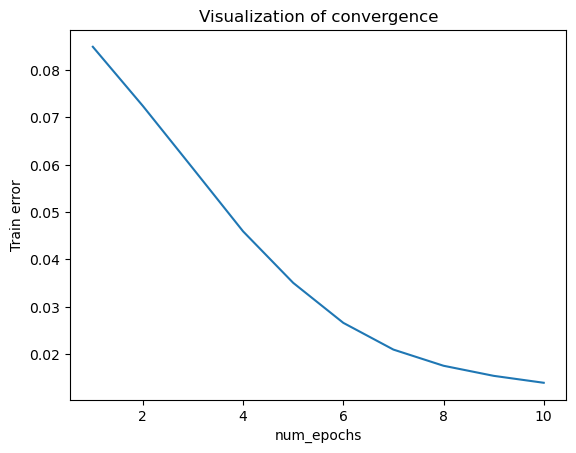

In [20]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [22]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            #images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [23]:
accuracy(val_set, model)

Accuracy of the model : 93.80 %


Text(0.5, 1.0, 'Prediction label: 1')

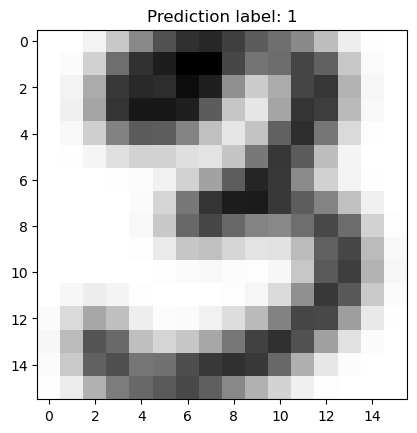

In [19]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [11]:
class Model_1L(nn.Module):
    
    def __init__(self):
        super(Model_1L, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network
        x = self.l1(inputs)
        outputs = F.softmax(x, dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [12]:
class Model_2L(nn.Module):
    
    def __init__(self, k, act_func):
        super(Model_2L, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Conv2d(1, 1, kernel_size = k)
        self.l2 = nn.Linear((16 - k + 1) * (16- k + 1), 10)
        self.activation = act_func
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        x = self.l1(inputs)
        x = self.activation(x) # You can put anything, as long as its Pytorch functions
        x = torch.flatten(x, start_dim=1)
        x = self.l2(x)
        outputs = F.softmax(x, dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [13]:
class Model_3L(nn.Module):
    
    def __init__(self, k, l, act_func):
        super(Model_3L, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Conv2d(1, 1, kernel_size = k)
        self.l2 = nn.Conv2d(1, 1, kernel_size = l)
        self.l3 = nn.Linear((16 - k - l + 2) * (16- k - l + 2), 10)
        self.activation = act_func
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        x = self.l1(inputs)
        x = self.activation(x) # You can put anything, as long as its Pytorch functions
        x = self.l2(x)
        x = self.activation(x)
        x = torch.flatten(x, start_dim=1)
        x = self.l3(x)
        outputs = F.softmax(x, dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [14]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, dim = 1):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            
            if dim == 1:
                y_pre = model(images.view(batch_size, -1))
            else:
                y_pre = model(images)
            #reshape - if necessary - the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {}'.format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

Epoch [1/20], Loss: 0.07539359474554656
Epoch [2/20], Loss: 0.0550767133602252
Epoch [3/20], Loss: 0.04204406454072645
Epoch [4/20], Loss: 0.03364558661046131
Epoch [5/20], Loss: 0.028073810753412577
Epoch [6/20], Loss: 0.024524266293349976
Epoch [7/20], Loss: 0.022092615672154328
Epoch [8/20], Loss: 0.020339756098498276
Epoch [9/20], Loss: 0.018997448699277227
Epoch [10/20], Loss: 0.017961810608782495
Epoch [11/20], Loss: 0.017087254633273305
Epoch [12/20], Loss: 0.016366407278595348
Epoch [13/20], Loss: 0.015763853141494713
Epoch [14/20], Loss: 0.015222763196798052
Epoch [15/20], Loss: 0.014782883042935267
Epoch [16/20], Loss: 0.014368962535712246
Epoch [17/20], Loss: 0.014007444074571438
Epoch [18/20], Loss: 0.013685238161609352
Epoch [19/20], Loss: 0.01339132417856793
Epoch [20/20], Loss: 0.013126710403400155
1


c:\Users\douil\anaconda3\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1/20], Loss: 0.08782895661890512
Epoch [2/20], Loss: 0.06954633091886835
Epoch [3/20], Loss: 0.03822184410722305
Epoch [4/20], Loss: 0.021644343951096143
Epoch [5/20], Loss: 0.01627184021519496
Epoch [6/20], Loss: 0.013888773404566264
Epoch [7/20], Loss: 0.012457133084244554
Epoch [8/20], Loss: 0.01150513368412551
Epoch [9/20], Loss: 0.010796964316687085
Epoch [10/20], Loss: 0.01027055329354576
Epoch [11/20], Loss: 0.009794274349066356
Epoch [12/20], Loss: 0.009451352398536972
Epoch [13/20], Loss: 0.009152957677664145
Epoch [14/20], Loss: 0.008905596899348894
Epoch [15/20], Loss: 0.008667588939109315
Epoch [16/20], Loss: 0.008460851954235597
Epoch [17/20], Loss: 0.008256119414266619
Epoch [18/20], Loss: 0.008120611054813097
Epoch [19/20], Loss: 0.007963849668170344
Epoch [20/20], Loss: 0.007829539711213631
2
Epoch [1/20], Loss: 0.08789727794627346
Epoch [2/20], Loss: 0.06643035678503421
Epoch [3/20], Loss: 0.032523987845828134
Epoch [4/20], Loss: 0.019196450996096258
Epoch [5/20

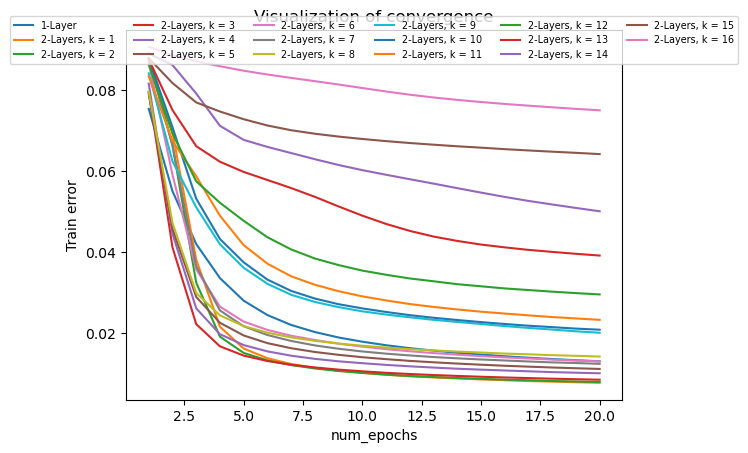

In [316]:
# Choose the hyperparameters for training: 
num_epochs = 20
batch_size = 10

# Create the model: 
model = Model_1L()

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error, label = "1-Layer")
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

for k in range(1, 17):
    print(k)
    model = Model_2L(k, F.relu)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)
    plt.plot(range(1, num_epochs+1), train_error, label = "2-Layers, k = "+ str(k))
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol = 6, fancybox=True, fontsize='x-small')
plt.show()

relu
Epoch [1/25], Loss: 0.08994358286261557
Epoch [2/25], Loss: 0.08736225524296379
Epoch [3/25], Loss: 0.050234950076943855
Epoch [4/25], Loss: 0.01724063869051557
Epoch [5/25], Loss: 0.012531699905278706
Epoch [6/25], Loss: 0.010883210630254327
Epoch [7/25], Loss: 0.009939960610730242
Epoch [8/25], Loss: 0.009535276379162199
Epoch [9/25], Loss: 0.009016403108463848
Epoch [10/25], Loss: 0.008635216216689522
Epoch [11/25], Loss: 0.008504130931969858
Epoch [12/25], Loss: 0.00816124839917848
Epoch [13/25], Loss: 0.007963222668684197
Epoch [14/25], Loss: 0.007648978930642169
Epoch [15/25], Loss: 0.007659896507548754
Epoch [16/25], Loss: 0.0074620528422911095
Epoch [17/25], Loss: 0.007437911547502368
Epoch [18/25], Loss: 0.007186085624717476
Epoch [19/25], Loss: 0.00720668902691775
Epoch [20/25], Loss: 0.007067265873105842
Epoch [21/25], Loss: 0.006977429444473834
Epoch [22/25], Loss: 0.006863989581083602
Epoch [23/25], Loss: 0.006788926084341635
Epoch [24/25], Loss: 0.006770046830882944


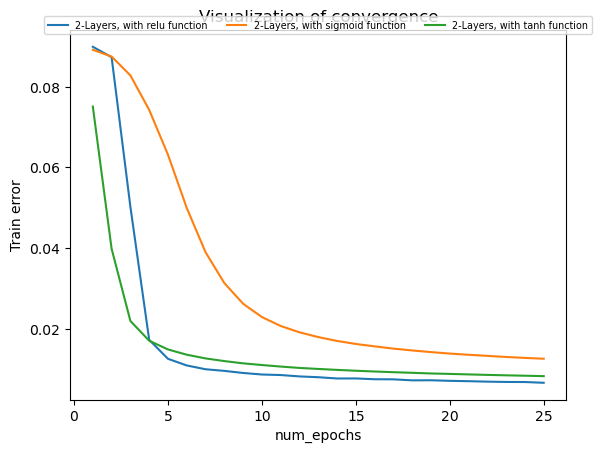

In [321]:
# Choose the hyperparameters for training: 
num_epochs = 25
batch_size = 10

for func in [F.relu, F.sigmoid, F.tanh]:
    print(func.__name__)
    model = Model_2L(3, func)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)
    plt.plot(range(1, num_epochs+1), train_error, label = "2-Layers, with " + func.__name__ + " function")
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol = 6, fancybox=True, fontsize='x-small')
plt.show()


relu
Epoch [1/100], Loss: 0.09000788761923716
Epoch [2/100], Loss: 0.08983049405117836
Epoch [3/100], Loss: 0.08968235008418558
Epoch [4/100], Loss: 0.08956287273516278
Epoch [5/100], Loss: 0.08946944468965136
Epoch [6/100], Loss: 0.08939837048451103
Epoch [7/100], Loss: 0.08934594364215924
Epoch [8/100], Loss: 0.08930774083981913
Epoch [9/100], Loss: 0.0892808292309442
Epoch [10/100], Loss: 0.0892621129627029
Epoch [11/100], Loss: 0.08924890336891016
Epoch [12/100], Loss: 0.08923972258965167
Epoch [13/100], Loss: 0.08923307577768967
Epoch [14/100], Loss: 0.08922848271826901
Epoch [15/100], Loss: 0.0892251784602801
Epoch [16/100], Loss: 0.08922290767232573
Epoch [17/100], Loss: 0.0892211617529392
Epoch [18/100], Loss: 0.08921999804675579
Epoch [19/100], Loss: 0.08921903410305584
Epoch [20/100], Loss: 0.08921816994746516
Epoch [21/100], Loss: 0.08921777023623394
Epoch [22/100], Loss: 0.0892174707601467
Epoch [23/100], Loss: 0.08921710244069503
Epoch [24/100], Loss: 0.08921683512628081
E

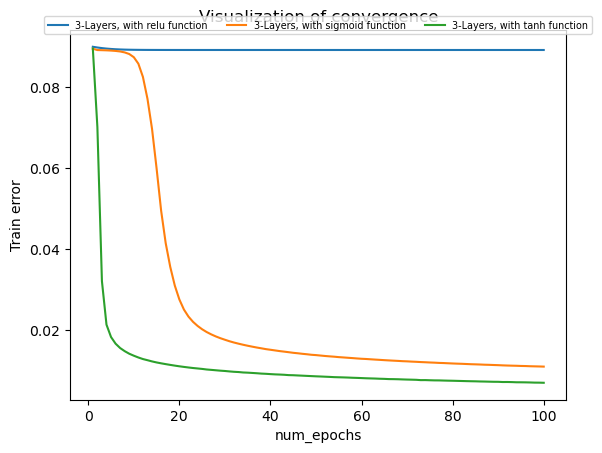

In [326]:
# Choose the hyperparameters for training: 
num_epochs = 100
batch_size = 10

for func in [F.relu, F.sigmoid, F.tanh]:
    print(func.__name__)
    model = Model_3L(3, 3, func)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)
    plt.plot(range(1, num_epochs+1), train_error, label = "3-Layers, with " + func.__name__ + " function")
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol = 6, fancybox=True, fontsize='x-small')
plt.show()


### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

In [15]:
class Best_Model(nn.Module):
    
    def __init__(self):
        super(Best_Model, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Conv2d(1, 1, kernel_size = 3)
        self.l2 = nn.Linear((16 - 3 + 1) * (16 - 3 + 1), 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        x = self.l1(inputs)
        x = torch.relu(x) # You can put anything, as long as its Pytorch functions
        x = torch.flatten(x, start_dim=1)
        x = self.l2(x)
        outputs = F.softmax(x, dim=1)# Use softmax as the activation function for the last layer
        return outputs

10
Epoch [1/25], Loss: 0.08700894031052803
Epoch [2/25], Loss: 0.04232152205814296
Epoch [3/25], Loss: 0.015430988180839147
Epoch [4/25], Loss: 0.012133643188620544
Epoch [5/25], Loss: 0.010718778116776477
Epoch [6/25], Loss: 0.009962189627926814
Epoch [7/25], Loss: 0.009395784111193281
Epoch [8/25], Loss: 0.009053115248114706
Epoch [9/25], Loss: 0.008676003802952437
Epoch [10/25], Loss: 0.008374579390637115
Epoch [11/25], Loss: 0.00813925072302406
Epoch [12/25], Loss: 0.008027874450738938
Epoch [13/25], Loss: 0.007906947684177039
Epoch [14/25], Loss: 0.007657881442864129
Epoch [15/25], Loss: 0.007455192347421184
Epoch [16/25], Loss: 0.007478779952013308
Epoch [17/25], Loss: 0.007396909418741868
Epoch [18/25], Loss: 0.0072838495131093825
Epoch [19/25], Loss: 0.007143113197825532
Epoch [20/25], Loss: 0.006985292253173249
Epoch [21/25], Loss: 0.00695033311559977
Epoch [22/25], Loss: 0.007025058608545342
Epoch [23/25], Loss: 0.006876189996125963
Epoch [24/25], Loss: 0.006736725789994682
E

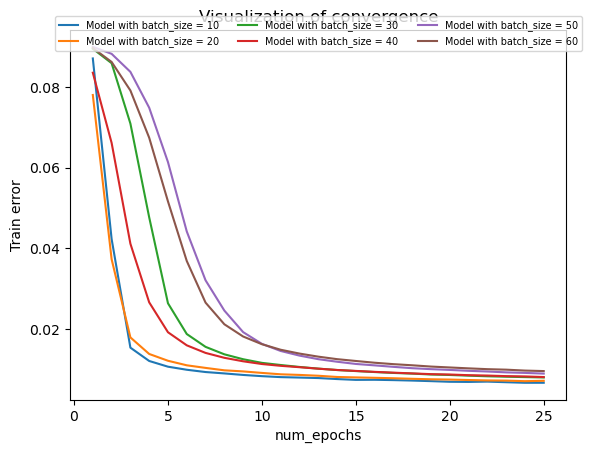

In [333]:
for bs in range(10, 61, 10):
    
    print(bs)
    
    # Choose the hyperparameters for training: 
    num_epochs = 25
    batch_size = bs

    # Create the model: 
    model = Best_Model()

    # Use mean squared loss function 
    criterion = nn.MSELoss()

    # Use SGD optimizer with a learning rate of 0.01
    # It is initialized on our model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label = "Model with batch_size = " + str(bs))
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol = 3, fancybox=True, fontsize='x-small')
plt.show()

0.001
Epoch [1/25], Loss: 0.09000604563703143
Epoch [2/25], Loss: 0.09000402897596349
Epoch [3/25], Loss: 0.09000201433897027
Epoch [4/25], Loss: 0.09000000368803732
Epoch [5/25], Loss: 0.08999799733360608
Epoch [6/25], Loss: 0.08999599436918901
Epoch [7/25], Loss: 0.08999399551500872
Epoch [8/25], Loss: 0.08999199904501444
Epoch [9/25], Loss: 0.08999000716954479
Epoch [10/25], Loss: 0.08998801878343023
Epoch [11/25], Loss: 0.08998603394875929
Epoch [12/25], Loss: 0.08998405159761498
Epoch [13/25], Loss: 0.08998207410176598
Epoch [14/25], Loss: 0.08998009939988451
Epoch [15/25], Loss: 0.08997812906901038
Epoch [16/25], Loss: 0.08997616219023859
Epoch [17/25], Loss: 0.08997419803092883
Epoch [18/25], Loss: 0.08997223785767958
Epoch [19/25], Loss: 0.0899702819809317
Epoch [20/25], Loss: 0.08996832892298692
Epoch [21/25], Loss: 0.08996637996286143
Epoch [22/25], Loss: 0.08996443370978036
Epoch [23/25], Loss: 0.08996249159177143
Epoch [24/25], Loss: 0.08996055268992975
Epoch [25/25], Loss:

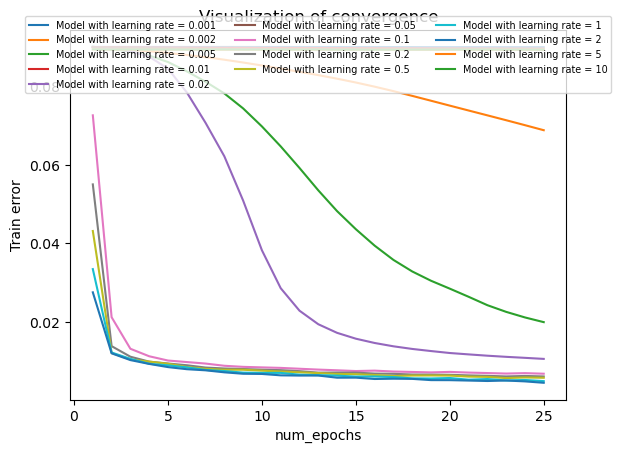

In [334]:
for lr in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]:
    
    print(lr)
    
    # Choose the hyperparameters for training: 
    num_epochs = 25
    batch_size = 10

    # Create the model: 
    model = Best_Model()

    # Use mean squared loss function 
    criterion = nn.MSELoss()

    # Use SGD optimizer with a learning rate of 0.01
    # It is initialized on our model
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)

    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label = "Model with learning rate = " + str(lr))
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol = 3, fancybox=True, fontsize='x-small')
plt.show()

SGD
Epoch [1/150], Loss: 0.08940454223503658
Epoch [2/150], Loss: 0.08924541889379428
Epoch [3/150], Loss: 0.08924563245226944
Epoch [4/150], Loss: 0.08924391154199846
Epoch [5/150], Loss: 0.08924461919814351
Epoch [6/150], Loss: 0.08924279236545163
Epoch [7/150], Loss: 0.08924546009550491
Epoch [8/150], Loss: 0.0892419620106618
Epoch [9/150], Loss: 0.0892405892908574
Epoch [10/150], Loss: 0.0892451547582943
Epoch [11/150], Loss: 0.08924238950014098
Epoch [12/150], Loss: 0.08924457959830764
Epoch [13/150], Loss: 0.08923961378633971
Epoch [14/150], Loss: 0.0892437911033631
Epoch [15/150], Loss: 0.08924582383284965
Epoch [16/150], Loss: 0.08923354691515376
Epoch [17/150], Loss: 0.08924753636121747
Epoch [18/150], Loss: 0.08924672387540336
Epoch [19/150], Loss: 0.08924888780961424
Epoch [20/150], Loss: 0.08924061803768069
Epoch [21/150], Loss: 0.08924503107865668
Epoch [22/150], Loss: 0.08924789226303494
Epoch [23/150], Loss: 0.08924217227846395
Epoch [24/150], Loss: 0.08924905547251308
E

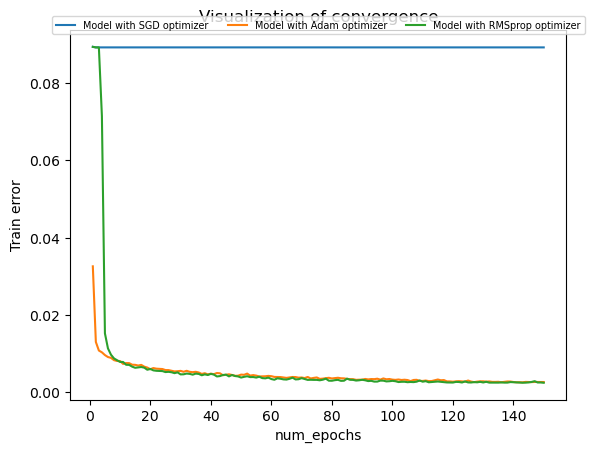

In [338]:
for opt in [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]:
    
    print(opt.__name__)
    
    # Choose the hyperparameters for training: 
    num_epochs = 150
    batch_size = 10

    # Create the model: 
    model = Best_Model()

    # Use mean squared loss function 
    criterion = nn.MSELoss()

    # Use SGD optimizer with a learning rate of 0.01
    # It is initialized on our model
    optimizer = torch.optim.SGD(model.parameters(), lr = 2)

    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)

    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label = "Model with " + opt.__name__ + " optimizer")
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol = 3, fancybox=True, fontsize='x-small')
plt.show()

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [26]:
class Best_Model_Cross(nn.Module):
    
    def __init__(self):
        super(Best_Model_Cross, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Conv2d(1, 1, kernel_size = 3)
        self.l2 = nn.Linear((16 - 3 + 1) * (16 - 3 + 1), 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        x = self.l1(inputs)
        x = torch.relu(x) # You can put anything, as long as its Pytorch functions
        x = torch.flatten(x, start_dim=1)
        outputs = self.l2(x)
        return outputs

In [17]:
# define a function for training
def train_cross(num_epochs, batch_size, criterion, optimizer, model, dataset, dim = 1):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            
            if dim == 1:
                y_pre = model(images.view(batch_size, -1))
            else:
                y_pre = model(images)
            #reshape - if necessary - the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
                     
            loss = criterion(y_pre, labels) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {}'.format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

Epoch [1/50], Loss: 1.8562251518170052
Epoch [2/50], Loss: 1.6405341001351668
Epoch [3/50], Loss: 1.6291686952114095
Epoch [4/50], Loss: 1.6160036355257048
Epoch [5/50], Loss: 1.6127243498961141
Epoch [6/50], Loss: 1.6101437362035111
Epoch [7/50], Loss: 1.602989068627357
Epoch [8/50], Loss: 1.5972147802511842
Epoch [9/50], Loss: 1.5951293557882325
Epoch [10/50], Loss: 1.590974044203757
Epoch [11/50], Loss: 1.5933736469348272
Epoch [12/50], Loss: 1.5901825338602074
Epoch [13/50], Loss: 1.59485259592533
Epoch [14/50], Loss: 1.5883529694875083
Epoch [15/50], Loss: 1.5867480566104235
Epoch [16/50], Loss: 1.5856484027703601
Epoch [17/50], Loss: 1.5878071995576188
Epoch [18/50], Loss: 1.5839712502559022
Epoch [19/50], Loss: 1.5837389383713387
Epoch [20/50], Loss: 1.582215627034506
Epoch [21/50], Loss: 1.585904689033825
Epoch [22/50], Loss: 1.5833238067229547
Epoch [23/50], Loss: 1.5836419435342126
Epoch [24/50], Loss: 1.5840591388940786
Epoch [25/50], Loss: 1.579700395862259
Epoch [26/50], L

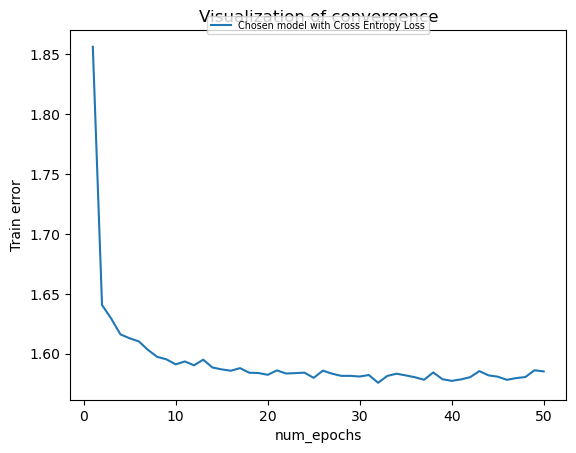

In [44]:
# Choose the hyperparameters for training: 
num_epochs = 50
batch_size = 10

# Create the model: 

#model = Best_Model_Cross()
model = Model_3L(3, 3, torch.relu)

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr = 0.2)

train_error = train_cross(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error, label = "Chosen model with Cross Entropy Loss")
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol = 3, fancybox=True, fontsize='x-small')
plt.show()

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [18]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [19]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [20]:
num_epochs = 200
batch_size = 10

# Create the model: 
#model = Best_Model()
model = Model_3L(3, 3, torch.relu)

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr = 2)

train_error = train_cross(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)
    
accuracy(test_set, model)

Epoch [1/200], Loss: 2.2791554331779493
Epoch [2/200], Loss: 2.2733710392316184
Epoch [3/200], Loss: 2.2731203921635976
Epoch [4/200], Loss: 2.2736436986923243
Epoch [5/200], Loss: 2.2735349027315768


KeyboardInterrupt: 

In [21]:
num_epochs = 50
batch_size = 10

# Create the model: 
#model = Best_Model()
model = Best_Model()

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr = 2)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)
    
accuracy(test_set, model)

Epoch [1/50], Loss: 0.023916229197180037
Epoch [2/50], Loss: 0.011639376275922129
Epoch [3/50], Loss: 0.009999279852754398
Epoch [4/50], Loss: 0.008920013709506831
Epoch [5/50], Loss: 0.008294634491331917
Epoch [6/50], Loss: 0.007740340701024493
Epoch [7/50], Loss: 0.0072398812545945174
Epoch [8/50], Loss: 0.00679151987477943
Epoch [9/50], Loss: 0.006897886437114048
Epoch [10/50], Loss: 0.006409469751909079
Epoch [11/50], Loss: 0.005936700835208571
Epoch [12/50], Loss: 0.005972646278076576
Epoch [13/50], Loss: 0.005948119708559056
Epoch [14/50], Loss: 0.005780943122862329
Epoch [15/50], Loss: 0.005590110635011511
Epoch [16/50], Loss: 0.00522330492255403
Epoch [17/50], Loss: 0.0051815229594759215
Epoch [18/50], Loss: 0.00524390015483731
Epoch [19/50], Loss: 0.004886347316910296
Epoch [20/50], Loss: 0.004827596693847136
Epoch [21/50], Loss: 0.004689968148652951
Epoch [22/50], Loss: 0.004621378415091759
Epoch [23/50], Loss: 0.004627883697980393
Epoch [24/50], Loss: 0.004507216533017522
Ep

NameError: name 'accuracy' is not defined

In [24]:
accuracy(test_set, model)

Accuracy of the model : 91.43 %
